# Onion Cell Intracellular Motion Analysis

Analysis of particle trajectories from onion epidermal cell microscopy video (`onion2.avi`, Session 4, 12 Feb 2026).

Particles were tracked using `track_onion_particles.py` (temporal median background subtraction + Hungarian algorithm linking). This notebook loads the MTrack2-format output and performs:

1. Track loading and segment extraction
2. Trajectory visualization
3. Displacement and velocity analysis
4. Mean-Squared Displacement (MSD) with power-law fitting
5. Classification of motion type (diffusive vs directed)
6. Quantitative summary and write-up

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import os
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
plt.rcParams['figure.dpi'] = 120
plt.rcParams['font.size'] = 11

## 1. Configuration

In [2]:
# === DATA FILE ===
DATA_FILE = '../Data/12-Feb/onion2-trackresults.txt'
FIGURES_DIR = 'figures'
os.makedirs(FIGURES_DIR, exist_ok=True)

# === TRACK SELECTION ===
NUM_BEST_SEGMENTS = 20        # Number of best track segments to use
MIN_TRACK_LENGTH = 20         # Minimum track segment length (frames)
MAX_DISPLACEMENT_PER_FRAME = 10  # px - split tracks at jumps larger than this
SUBTRACT_DRIFT = False        # For streaming, do NOT subtract drift (it IS the signal)

# === EXPERIMENTAL PARAMETERS ===
# NOTE: onion2.avi reports 1.0 fps in metadata. Adjust if actual frame rate is known.
FRAME_RATE = 1.0              # fps (from AVI metadata; update if known)
dt = 1.0 / FRAME_RATE         # seconds per frame

# Pixel calibration - UPDATE based on objective used for this video
# 68.4 nm/px at 100x oil (confirmed Sessions 1, 3)
# If 40x was used: ~171 nm/px; if 10x: ~684 nm/px
PIXEL_SIZE = 0.0684           # um/px (100x oil) - CHANGE if different objective

print('=' * 60)
print('ONION CELL INTRACELLULAR MOTION ANALYSIS')
print('=' * 60)
print(f'  Data file: {DATA_FILE}')
print(f'  Frame rate: {FRAME_RATE} fps  (dt = {dt:.4f} s)')
print(f'  Pixel size: {PIXEL_SIZE} um/px ({PIXEL_SIZE*1000:.1f} nm/px)')
print(f'  Track split threshold: {MAX_DISPLACEMENT_PER_FRAME} px/frame')
print(f'  Min segment length: {MIN_TRACK_LENGTH} frames')
print(f'  Drift subtraction: {"ON" if SUBTRACT_DRIFT else "OFF"}')

ONION CELL INTRACELLULAR MOTION ANALYSIS
  Data file: ../Data/12-Feb/onion2-trackresults.txt
  Frame rate: 1.0 fps  (dt = 1.0000 s)
  Pixel size: 0.0684 um/px (68.4 nm/px)
  Track split threshold: 10 px/frame
  Min segment length: 20 frames
  Drift subtraction: OFF


## 2. Load Data and Extract Track Segments

In [3]:
def load_mtrack2_data(file_path):
    """Load MTrack2 output file and return cleaned data matrix (frames x 2*particles)."""
    my_data = np.genfromtxt(file_path, delimiter='\t', skip_header=2,
                           skip_footer=1, invalid_raise=False)
    
    # Remove frame column (0) and every flag column (3, 6, 9, ...)
    A = np.zeros(my_data.shape[1]//3+1, dtype=int)
    for i in range(my_data.shape[1]//3+1):
        A[i] = 3*i
    new_data = np.delete(my_data, A, axis=1)
    
    # Sort data - move NaN values to the end
    mask = np.isnan(new_data)
    new_mask = np.zeros(mask.shape)
    for ind, value in enumerate(mask):
        new_mask[ind, :] = ~value * (ind + 1)
    new_mask = new_mask.astype(np.int_)
    
    for row_index, row in enumerate(new_mask):
        for col_index, item in enumerate(row):
            if item == 0:
                new_mask[row_index][col_index] = (new_mask.shape[0] + 5)
    
    for i in range(new_mask.shape[1]):
        new_mask[:, i] = np.sort(new_mask[:, i])
    
    data = np.empty((mask.shape[0], mask.shape[1]))
    data[:, :] = np.nan
    
    for i in range(new_mask.shape[0]):
        for j in range(new_mask.shape[1]):
            temp = new_mask[i, j]
            if temp < (new_mask.shape[0]):
                data[i, j] = new_data[temp, j]
    
    return data


def split_tracks_at_jumps(data, min_length, max_jump_px):
    """Extract valid trajectory segments, splitting at large jumps."""
    segments = []
    n_particles = data.shape[1] // 2
    segment_id = 0
    
    for i in range(n_particles):
        x_raw = data[:, i * 2]
        y_raw = data[:, i * 2 + 1]
        
        valid_mask = ~np.isnan(x_raw) & ~np.isnan(y_raw)
        x_clean = x_raw[valid_mask]
        y_clean = y_raw[valid_mask]
        
        if len(x_clean) < min_length:
            continue
        
        dx = np.diff(x_clean)
        dy = np.diff(y_clean)
        steps = np.sqrt(dx**2 + dy**2)
        
        bad_jump_indices = np.where(steps > max_jump_px)[0]
        
        if len(bad_jump_indices) == 0:
            segment_id += 1
            segments.append({
                'x': x_clean, 'y': y_clean,
                'id': segment_id, 'original_particle': i + 1,
                'length': len(x_clean)
            })
        else:
            split_indices = bad_jump_indices + 1
            x_segs = np.split(x_clean, split_indices)
            y_segs = np.split(y_clean, split_indices)
            for xs, ys in zip(x_segs, y_segs):
                if len(xs) >= min_length:
                    segment_id += 1
                    segments.append({
                        'x': xs, 'y': ys,
                        'id': segment_id, 'original_particle': i + 1,
                        'length': len(xs)
                    })
    
    segments.sort(key=lambda s: s['length'], reverse=True)
    return segments


def linear(t, slope, intercept):
    return slope * t + intercept

def power_law(t, K, alpha):
    return K * t**alpha

print('Helper functions defined.')

Helper functions defined.


In [4]:
# Load data
print(f'Loading: {DATA_FILE}')
data = load_mtrack2_data(DATA_FILE)
total_frames = data.shape[0]
total_particles = data.shape[1] // 2
print(f'  Total frames: {total_frames}')
print(f'  Total particles detected: {total_particles}')

# Split tracks
segments = split_tracks_at_jumps(data, MIN_TRACK_LENGTH, MAX_DISPLACEMENT_PER_FRAME)
print(f'\nTrack splitting (threshold: {MAX_DISPLACEMENT_PER_FRAME} px/frame):')
print(f'  Valid segments: {len(segments)}')

# Select top N
n_to_use = min(NUM_BEST_SEGMENTS, len(segments))
selected = segments[:n_to_use]
print(f'  Using top {n_to_use} segments (by length)')

total_steps = sum(s['length'] for s in selected)
print(f'  Total data points: {total_steps}')
print(f'\nSelected segments:')
for s in selected:
    net = np.sqrt((s['x'][-1]-s['x'][0])**2 + (s['y'][-1]-s['y'][0])**2)
    print(f'  Seg {s["id"]:3d}: {s["length"]:3d} frames, '
          f'net displacement = {net:.1f} px ({net*PIXEL_SIZE:.2f} um)')

Loading: ../Data/12-Feb/onion2-trackresults.txt
  Total frames: 240
  Total particles detected: 1246

Track splitting (threshold: 10 px/frame):
  Valid segments: 1099
  Using top 20 segments (by length)
  Total data points: 4780

Selected segments:
  Seg 668: 239 frames, net displacement = 17.9 px (1.22 um)
  Seg 670: 239 frames, net displacement = 21.4 px (1.46 um)
  Seg 671: 239 frames, net displacement = 78.3 px (5.35 um)
  Seg 672: 239 frames, net displacement = 39.8 px (2.73 um)
  Seg 673: 239 frames, net displacement = 22.5 px (1.54 um)
  Seg 674: 239 frames, net displacement = 77.6 px (5.31 um)
  Seg 676: 239 frames, net displacement = 39.8 px (2.72 um)
  Seg 677: 239 frames, net displacement = 36.6 px (2.50 um)
  Seg 680: 239 frames, net displacement = 24.7 px (1.69 um)
  Seg 685: 239 frames, net displacement = 20.0 px (1.37 um)
  Seg 690: 239 frames, net displacement = 48.1 px (3.29 um)
  Seg 692: 239 frames, net displacement = 73.8 px (5.05 um)
  Seg 693: 239 frames, net disp

## 3. Trajectory Visualization

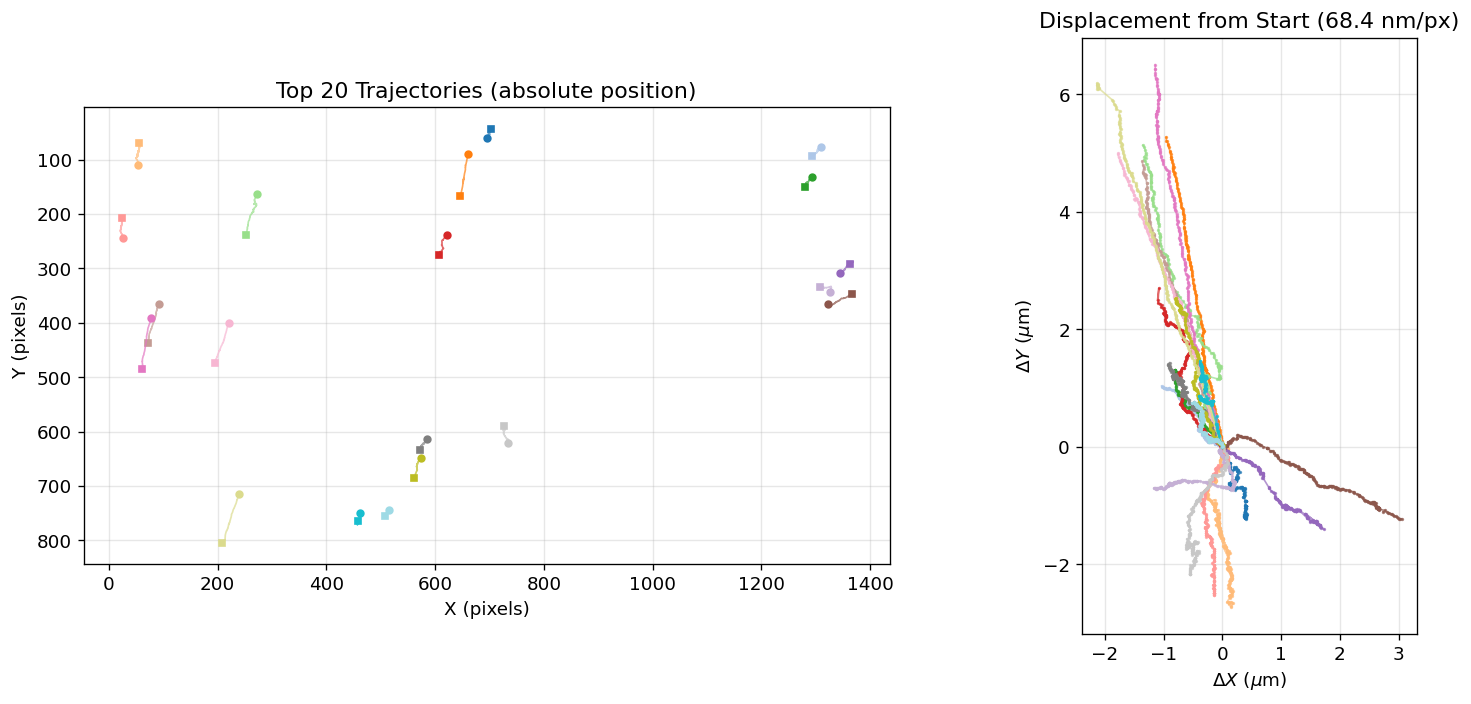

Saved: figures/onion_trajectories.png


In [5]:
# Plot selected trajectories (in microns, centered at origin)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Left: pixel coordinates (absolute position)
ax = axes[0]
colors = plt.cm.tab20(np.linspace(0, 1, n_to_use))
for seg, c in zip(selected, colors):
    ax.plot(seg['x'], seg['y'], '-', linewidth=1, color=c, alpha=0.7)
    ax.plot(seg['x'][0], seg['y'][0], 'o', color=c, markersize=4)
    ax.plot(seg['x'][-1], seg['y'][-1], 's', color=c, markersize=4)
ax.set_xlabel('X (pixels)')
ax.set_ylabel('Y (pixels)')
ax.set_title(f'Top {n_to_use} Trajectories (absolute position)')
ax.set_aspect('equal')
ax.invert_yaxis()  # image coordinates
ax.grid(True, alpha=0.3)

# Right: displacement from start (in microns)
ax = axes[1]
for seg, c in zip(selected, colors):
    x_um = (seg['x'] - seg['x'][0]) * PIXEL_SIZE
    y_um = (seg['y'] - seg['y'][0]) * PIXEL_SIZE
    ax.plot(x_um, y_um, '-o', markersize=1, linewidth=1, color=c, alpha=0.7)
ax.set_xlabel(r'$\Delta X$ ($\mu$m)')
ax.set_ylabel(r'$\Delta Y$ ($\mu$m)')
ax.set_title(f'Displacement from Start ({PIXEL_SIZE*1000:.1f} nm/px)')
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)

plt.tight_layout()
fig.savefig(os.path.join(FIGURES_DIR, 'onion_trajectories.png'), dpi=150, bbox_inches='tight')
plt.show()
print(f'Saved: figures/onion_trajectories.png')

## 4. Displacement and Velocity Analysis

In [6]:
# Collect all frame-to-frame displacements
all_dx_px = []
all_dy_px = []
all_speeds_px = []  # px/frame

for seg in selected:
    dx = np.diff(seg['x'])
    dy = np.diff(seg['y'])
    all_dx_px.extend(dx)
    all_dy_px.extend(dy)
    all_speeds_px.extend(np.sqrt(dx**2 + dy**2))

all_dx_px = np.array(all_dx_px)
all_dy_px = np.array(all_dy_px)
all_speeds_px = np.array(all_speeds_px)

# Convert to physical units
all_dx_um = all_dx_px * PIXEL_SIZE
all_dy_um = all_dy_px * PIXEL_SIZE
all_speeds_um_s = all_speeds_px * PIXEL_SIZE / dt  # um/s

print('Frame-to-frame displacement statistics:')
print(f'  N steps: {len(all_dx_px)}')
print(f'  dx: mean={np.mean(all_dx_um):.4f} um, std={np.std(all_dx_um):.4f} um')
print(f'  dy: mean={np.mean(all_dy_um):.4f} um, std={np.std(all_dy_um):.4f} um')
print(f'  Speed: mean={np.mean(all_speeds_um_s):.4f} um/s, '
      f'median={np.median(all_speeds_um_s):.4f} um/s, '
      f'max={np.max(all_speeds_um_s):.4f} um/s')
print(f'  In pixels: mean step = {np.mean(all_speeds_px):.3f} px/frame')

Frame-to-frame displacement statistics:
  N steps: 4760
  dx: mean=-0.0023 um, std=0.0196 um
  dy: mean=0.0067 um, std=0.0303 um
  Speed: mean=0.0228 um/s, median=0.0177 um/s, max=0.4933 um/s
  In pixels: mean step = 0.333 px/frame


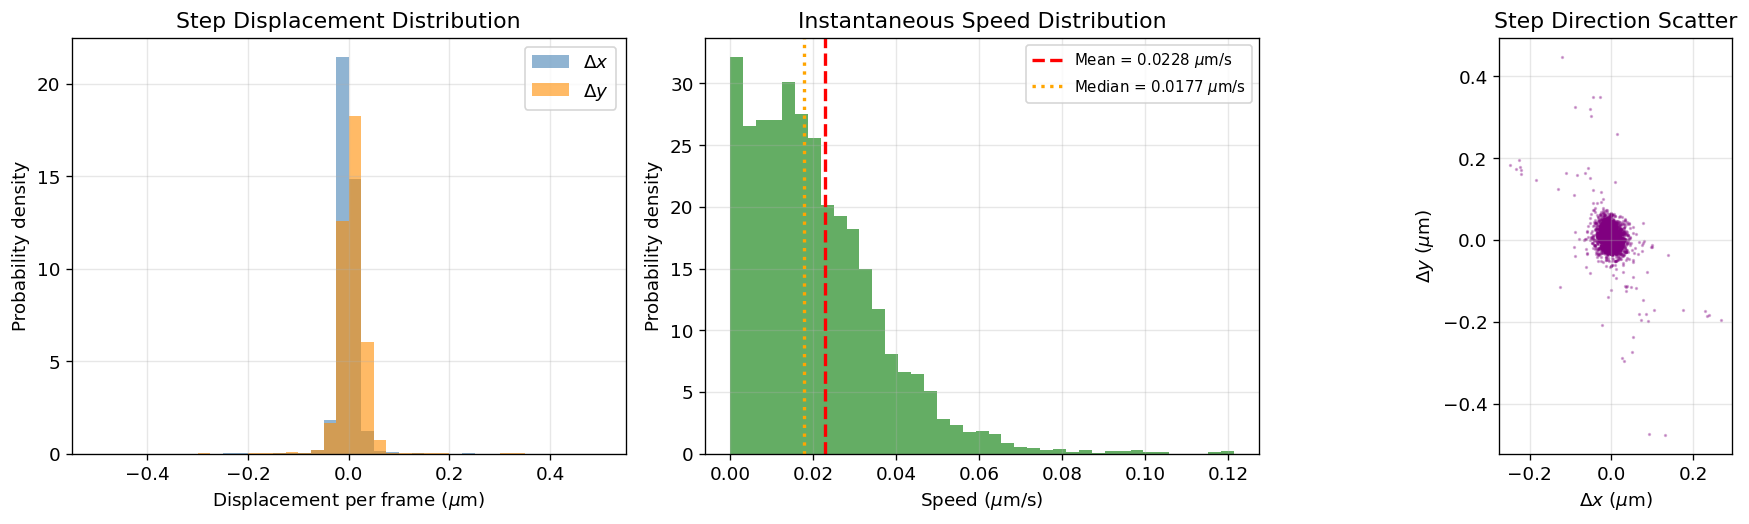

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4.5))

# (a) Displacement histograms (X and Y)
ax = axes[0]
bins_d = np.linspace(-0.5, 0.5, 41)
ax.hist(all_dx_um, bins=bins_d, alpha=0.6, label=r'$\Delta x$', color='steelblue', density=True)
ax.hist(all_dy_um, bins=bins_d, alpha=0.6, label=r'$\Delta y$', color='darkorange', density=True)
ax.set_xlabel(r'Displacement per frame ($\mu$m)')
ax.set_ylabel('Probability density')
ax.set_title('Step Displacement Distribution')
ax.legend()
ax.grid(True, alpha=0.3)

# (b) Speed histogram
ax = axes[1]
bins_s = np.linspace(0, np.percentile(all_speeds_um_s, 99), 40)
ax.hist(all_speeds_um_s, bins=bins_s, color='forestgreen', alpha=0.7, density=True)
ax.axvline(np.mean(all_speeds_um_s), color='red', linestyle='--', linewidth=2,
           label=f'Mean = {np.mean(all_speeds_um_s):.4f} $\\mu$m/s')
ax.axvline(np.median(all_speeds_um_s), color='orange', linestyle=':', linewidth=2,
           label=f'Median = {np.median(all_speeds_um_s):.4f} $\\mu$m/s')
ax.set_xlabel(r'Speed ($\mu$m/s)')
ax.set_ylabel('Probability density')
ax.set_title('Instantaneous Speed Distribution')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# (c) Displacement scatter (dx vs dy)
ax = axes[2]
ax.scatter(all_dx_um, all_dy_um, s=1, alpha=0.3, color='purple')
ax.set_xlabel(r'$\Delta x$ ($\mu$m)')
ax.set_ylabel(r'$\Delta y$ ($\mu$m)')
ax.set_title('Step Direction Scatter')
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)

plt.tight_layout()
fig.savefig(os.path.join(FIGURES_DIR, 'onion_displacement_stats.png'), dpi=150, bbox_inches='tight')
plt.show()

## 5. Mean-Squared Displacement (MSD) Analysis

For 2D motion:
$$\text{MSD}(\tau) = \langle [\mathbf{r}(t+\tau) - \mathbf{r}(t)]^2 \rangle$$

- **Diffusive** (Brownian): $\text{MSD} = 4D\tau$ ($\alpha = 1$)
- **Directed/ballistic**: $\text{MSD} = v^2 \tau^2$ ($\alpha = 2$)
- **General**: $\text{MSD} = K \tau^\alpha$ where $\alpha$ classifies the motion type

In [8]:
# Compute MSD for each selected segment
min_track = min(s['length'] for s in selected)
max_lag = min(min_track // 2, 50)
print(f'Shortest selected track: {min_track} frames')
print(f'Max lag for MSD: {max_lag} frames ({max_lag * dt:.1f} s)')

all_MSDs = []
for seg in selected:
    x = seg['x'].copy()
    y = seg['y'].copy()
    
    if SUBTRACT_DRIFT:
        x = x - np.mean(x)
        y = y - np.mean(y)
    
    MSD_seg = np.zeros(max_lag)
    n_frames = len(x)
    
    for lag in range(max_lag):
        if n_frames > lag and lag > 0:
            dx_lag = x[lag:] - x[:-lag]
            dy_lag = y[lag:] - y[:-lag]
            r_sq = dx_lag**2 + dy_lag**2
            MSD_seg[lag] = np.mean(r_sq)
    
    all_MSDs.append(MSD_seg)

all_MSDs = np.array(all_MSDs)
MSD_px = np.mean(all_MSDs, axis=0)
MSD_err_px = np.std(all_MSDs, axis=0) / np.sqrt(len(selected))

# Convert to physical units
MSD_um = MSD_px * PIXEL_SIZE**2
MSD_err_um = MSD_err_px * PIXEL_SIZE**2
lag_times = np.arange(max_lag) * dt

print(f'\nMSD at selected lags:')
for lag_idx in [1, 2, 5, 10, 20, 30, 40]:
    if lag_idx < max_lag:
        print(f'  tau={lag_times[lag_idx]:.1f} s: MSD = {MSD_um[lag_idx]:.6f} +/- {MSD_err_um[lag_idx]:.6f} um^2')

Shortest selected track: 239 frames
Max lag for MSD: 50 frames (50.0 s)

MSD at selected lags:
  tau=1.0 s: MSD = 0.001351 +/- 0.000300 um^2
  tau=2.0 s: MSD = 0.002639 +/- 0.000426 um^2
  tau=5.0 s: MSD = 0.009373 +/- 0.001446 um^2
  tau=10.0 s: MSD = 0.030494 +/- 0.005525 um^2
  tau=20.0 s: MSD = 0.107644 +/- 0.021598 um^2
  tau=30.0 s: MSD = 0.230711 +/- 0.048407 um^2
  tau=40.0 s: MSD = 0.398737 +/- 0.086174 um^2


In [9]:
# === FIT 1: Linear fit (MSD = 4D*t + offset) ===
n_fit_linear = min(15, max_lag // 3)
fit_t = lag_times[1:n_fit_linear+1]
fit_msd = MSD_um[1:n_fit_linear+1]
fit_err = MSD_err_um[1:n_fit_linear+1]
fit_err = np.where(fit_err > 0, fit_err, 1e-10)

try:
    popt_lin, pcov_lin = curve_fit(linear, fit_t, fit_msd,
                                   sigma=fit_err, absolute_sigma=True, p0=[1, 0])
    perr_lin = np.sqrt(np.diag(pcov_lin))
    slope_lin = popt_lin[0]
    slope_err_lin = perr_lin[0]
    D_linear = slope_lin / 4  # 2D diffusion: MSD = 4Dt
    D_linear_err = slope_err_lin / 4
except Exception:
    coeffs = np.polyfit(fit_t, fit_msd, 1)
    slope_lin = coeffs[0]
    slope_err_lin = 0
    D_linear = slope_lin / 4
    D_linear_err = 0

print('Linear fit (short-lag regime, lags 1-{})'.format(n_fit_linear))
print(f'  Slope = {slope_lin:.6f} +/- {slope_err_lin:.6f} um^2/s')
print(f'  D_eff (from slope/4) = {D_linear:.6f} +/- {D_linear_err:.6f} um^2/s')

# === FIT 2: Power-law fit (MSD = K * t^alpha) on log-log ===
# Use lags 1 through max_lag//2 for power law
n_fit_power = max_lag // 2
pl_t = lag_times[1:n_fit_power+1]
pl_msd = MSD_um[1:n_fit_power+1]
pl_err = MSD_err_um[1:n_fit_power+1]
pl_err = np.where(pl_err > 0, pl_err, 1e-10)

try:
    popt_pl, pcov_pl = curve_fit(power_law, pl_t, pl_msd,
                                  sigma=pl_err, absolute_sigma=True,
                                  p0=[0.001, 1.5], maxfev=5000)
    perr_pl = np.sqrt(np.diag(pcov_pl))
    K_fit = popt_pl[0]
    alpha_fit = popt_pl[1]
    K_err = perr_pl[0]
    alpha_err = perr_pl[1]
except Exception:
    # Fallback: log-log linear regression
    log_t = np.log(pl_t)
    log_msd = np.log(pl_msd)
    coeffs = np.polyfit(log_t, log_msd, 1)
    alpha_fit = coeffs[0]
    K_fit = np.exp(coeffs[1])
    alpha_err = 0
    K_err = 0

print(f'\nPower-law fit (lags 1-{n_fit_power}): MSD = K * t^alpha')
print(f'  K = {K_fit:.6f} +/- {K_err:.6f} um^2/s^alpha')
print(f'  alpha = {alpha_fit:.3f} +/- {alpha_err:.3f}')
print()
if alpha_fit > 1.7:
    motion_type = 'BALLISTIC / DIRECTED'
elif alpha_fit > 1.2:
    motion_type = 'SUPERDIFFUSIVE (directed + random)'
elif alpha_fit > 0.8:
    motion_type = 'DIFFUSIVE (Brownian-like)'
else:
    motion_type = 'SUBDIFFUSIVE (confined)'
print(f'  Motion classification: {motion_type}')

Linear fit (short-lag regime, lags 1-15)
  Slope = 0.002491 +/- 0.000151 um^2/s
  D_eff (from slope/4) = 0.000623 +/- 0.000038 um^2/s

Power-law fit (lags 1-25): MSD = K * t^alpha
  K = 0.000699 +/- 0.000084 um^2/s^alpha
  alpha = 1.662 +/- 0.052

  Motion classification: SUPERDIFFUSIVE (directed + random)


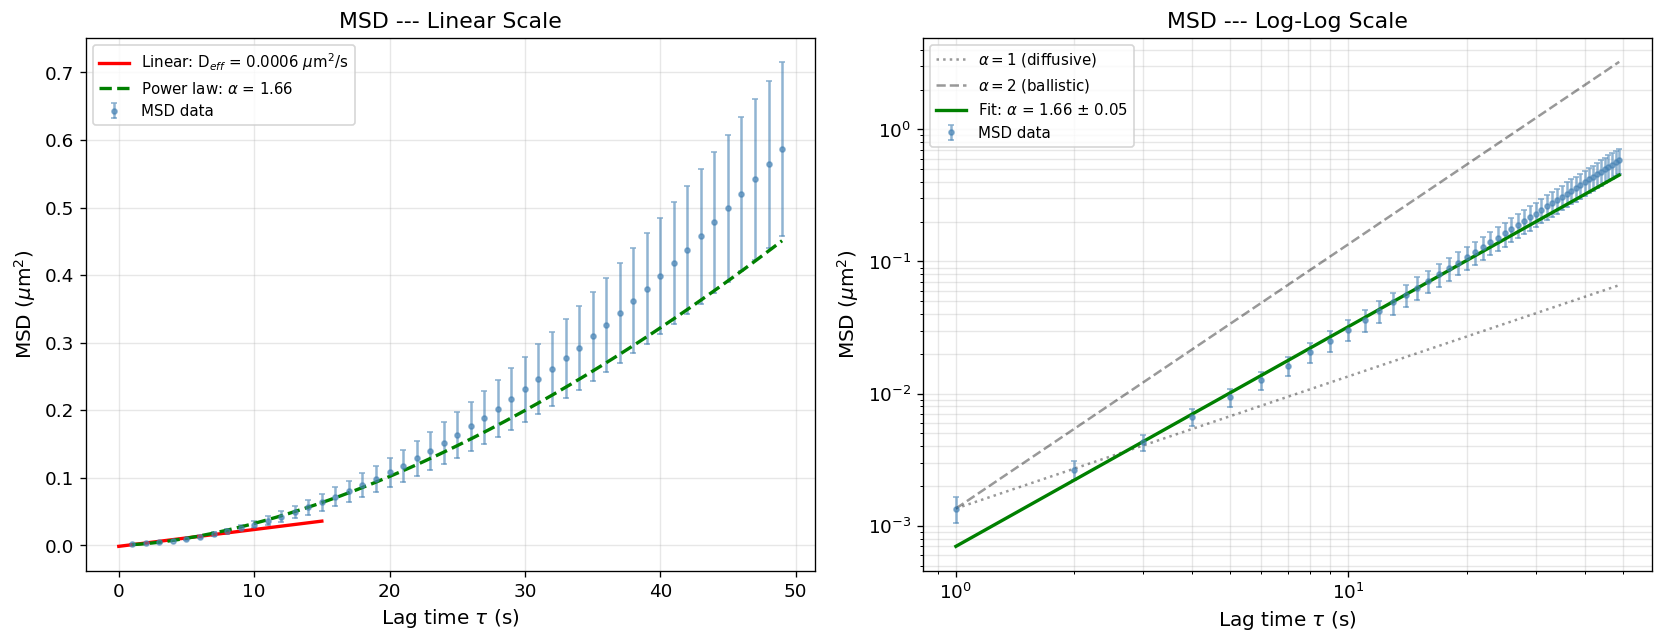

Saved: figures/onion_msd_analysis.png


In [10]:
# MSD Plot: linear and log-log
fig, axes = plt.subplots(1, 2, figsize=(14, 5.5))

# --- (a) Linear scale ---
ax = axes[0]
ax.errorbar(lag_times[1:], MSD_um[1:], yerr=MSD_err_um[1:],
            fmt='o', markersize=3, capsize=2, alpha=0.6, color='steelblue',
            label='MSD data')

# Linear fit line
fit_line_t = np.linspace(0, lag_times[n_fit_linear], 100)
ax.plot(fit_line_t, linear(fit_line_t, *popt_lin), 'r-', linewidth=2,
        label=f'Linear: D$_{{eff}}$ = {D_linear:.4f} $\\mu$m$^2$/s')

# Power-law fit line
pl_line_t = np.linspace(dt, lag_times[-1], 200)
ax.plot(pl_line_t, power_law(pl_line_t, K_fit, alpha_fit), 'g--', linewidth=2,
        label=f'Power law: $\\alpha$ = {alpha_fit:.2f}')

ax.set_xlabel('Lag time $\\tau$ (s)', fontsize=12)
ax.set_ylabel(r'MSD ($\mu$m$^2$)', fontsize=12)
ax.set_title('MSD --- Linear Scale')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# --- (b) Log-log scale ---
ax = axes[1]
valid = MSD_um[1:] > 0
ax.errorbar(lag_times[1:][valid], MSD_um[1:][valid], yerr=MSD_err_um[1:][valid],
            fmt='o', markersize=3, capsize=2, alpha=0.6, color='steelblue',
            label='MSD data')

# Reference slopes
ref_t = np.logspace(np.log10(dt), np.log10(lag_times[-1]), 50)
msd_at_1 = MSD_um[1]
ax.plot(ref_t, msd_at_1 * (ref_t/dt)**1, 'k:', alpha=0.4, linewidth=1.5,
        label=r'$\alpha=1$ (diffusive)')
ax.plot(ref_t, msd_at_1 * (ref_t/dt)**2, 'k--', alpha=0.4, linewidth=1.5,
        label=r'$\alpha=2$ (ballistic)')

# Power-law fit
ax.plot(pl_line_t, power_law(pl_line_t, K_fit, alpha_fit), 'g-', linewidth=2,
        label=f'Fit: $\\alpha$ = {alpha_fit:.2f} $\\pm$ {alpha_err:.2f}')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Lag time $\\tau$ (s)', fontsize=12)
ax.set_ylabel(r'MSD ($\mu$m$^2$)', fontsize=12)
ax.set_title('MSD --- Log-Log Scale')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3, which='both')

plt.tight_layout()
fig.savefig(os.path.join(FIGURES_DIR, 'onion_msd_analysis.png'), dpi=150, bbox_inches='tight')
plt.show()
print(f'Saved: figures/onion_msd_analysis.png')

## 6. Per-Segment MSD and Velocity

In [11]:
# Compute per-segment statistics
seg_stats = []
for seg in selected:
    x = seg['x']
    y = seg['y']
    n = len(x)
    
    # Net displacement
    net_disp_px = np.sqrt((x[-1]-x[0])**2 + (y[-1]-y[0])**2)
    net_disp_um = net_disp_px * PIXEL_SIZE
    
    # Path length
    dx = np.diff(x)
    dy = np.diff(y)
    steps = np.sqrt(dx**2 + dy**2)
    path_length_um = np.sum(steps) * PIXEL_SIZE
    
    # Mean speed
    mean_speed = np.mean(steps) * PIXEL_SIZE / dt
    
    # Net velocity
    duration = (n - 1) * dt
    net_velocity = net_disp_um / duration if duration > 0 else 0
    
    # Direction (angle of net displacement)
    angle = np.degrees(np.arctan2(y[-1]-y[0], x[-1]-x[0]))
    
    # Directionality ratio (net/path)
    directionality = net_disp_um / path_length_um if path_length_um > 0 else 0
    
    seg_stats.append({
        'id': seg['id'], 'length': n,
        'net_disp_um': net_disp_um, 'path_length_um': path_length_um,
        'mean_speed_um_s': mean_speed, 'net_velocity_um_s': net_velocity,
        'angle_deg': angle, 'directionality': directionality
    })

# Print table
print(f'{"Seg":>4s} {"Frames":>6s} {"Net disp":>10s} {"Path len":>10s} '
      f'{"Mean spd":>10s} {"Net vel":>10s} {"Dir ratio":>9s} {"Angle":>7s}')
print(f'{"":>4s} {"":>6s} {"(um)":>10s} {"(um)":>10s} '
      f'{"(um/s)":>10s} {"(um/s)":>10s} {"":>9s} {"(deg)":>7s}')
print('-' * 75)
for s in seg_stats:
    print(f'{s["id"]:4d} {s["length"]:6d} {s["net_disp_um"]:10.4f} {s["path_length_um"]:10.4f} '
          f'{s["mean_speed_um_s"]:10.4f} {s["net_velocity_um_s"]:10.4f} '
          f'{s["directionality"]:9.3f} {s["angle_deg"]:7.1f}')

# Summary
print(f'\nSummary across {len(seg_stats)} segments:')
speeds = [s['mean_speed_um_s'] for s in seg_stats]
dirs = [s['directionality'] for s in seg_stats]
print(f'  Mean speed: {np.mean(speeds):.4f} +/- {np.std(speeds):.4f} um/s')
print(f'  Directionality ratio: {np.mean(dirs):.3f} +/- {np.std(dirs):.3f}')
print(f'    (0 = random walk, 1 = perfectly straight line)')

 Seg Frames   Net disp   Path len   Mean spd    Net vel Dir ratio   Angle
                  (um)       (um)     (um/s)     (um/s)             (deg)
---------------------------------------------------------------------------
 668    239     1.2240     3.9559     0.0166     0.0051     0.309   -70.6
 670    239     1.4611     4.5685     0.0192     0.0061     0.320   135.1
 671    239     5.3535     7.8765     0.0331     0.0225     0.680   100.3
 672    239     2.7255     9.2900     0.0390     0.0115     0.293   -87.1
 673    239     1.5378     2.8866     0.0121     0.0065     0.533   121.8
 674    239     5.3065     7.5700     0.0318     0.0223     0.701   104.8
 676    239     2.7249     4.3849     0.0184     0.0114     0.621   113.9
 677    239     2.5016     4.9247     0.0207     0.0105     0.508   -93.2
 680    239     1.6924     6.7578     0.0284     0.0071     0.250   -39.2
 685    239     1.3650     3.4678     0.0146     0.0057     0.394  -148.8
 690    239     3.2894     4.7694   

## 7. Quantitative Summary

In [12]:
print('=' * 70)
print('QUANTITATIVE SUMMARY --- ONION CELL INTRACELLULAR MOTION')
print('=' * 70)

print(f'\nExperimental Conditions:')
print(f'  Sample: Onion epidermal cells')
print(f'  Video: onion2.avi ({total_frames} frames at {FRAME_RATE} fps)')
print(f'  Pixel size: {PIXEL_SIZE} um/px ({PIXEL_SIZE*1000:.1f} nm/px)')
print(f'  Duration: {total_frames * dt:.1f} s')

print(f'\nTracking Results:')
print(f'  Total particles detected: {total_particles}')
print(f'  Valid track segments (>={MIN_TRACK_LENGTH} frames): {len(segments)}')
print(f'  Segments used for analysis: {n_to_use}')
print(f'  Total data points: {total_steps}')

print(f'\nVelocity Analysis:')
print(f'  Mean instantaneous speed: {np.mean(all_speeds_um_s):.4f} um/s')
print(f'  Median instantaneous speed: {np.median(all_speeds_um_s):.4f} um/s')
print(f'  Std of speed: {np.std(all_speeds_um_s):.4f} um/s')
print(f'  Mean directionality ratio: {np.mean(dirs):.3f} +/- {np.std(dirs):.3f}')

print(f'\nMSD Analysis:')
print(f'  Linear fit (short lag): D_eff = {D_linear:.6f} +/- {D_linear_err:.6f} um^2/s')
print(f'  Power-law exponent: alpha = {alpha_fit:.3f} +/- {alpha_err:.3f}')
print(f'  Motion type: {motion_type}')

print(f'\n' + '=' * 70)

QUANTITATIVE SUMMARY --- ONION CELL INTRACELLULAR MOTION

Experimental Conditions:
  Sample: Onion epidermal cells
  Video: onion2.avi (240 frames at 1.0 fps)
  Pixel size: 0.0684 um/px (68.4 nm/px)
  Duration: 240.0 s

Tracking Results:
  Total particles detected: 1246
  Valid track segments (>=20 frames): 1099
  Segments used for analysis: 20
  Total data points: 4780

Velocity Analysis:
  Mean instantaneous speed: 0.0228 um/s
  Median instantaneous speed: 0.0177 um/s
  Std of speed: 0.0289 um/s
  Mean directionality ratio: 0.540 +/- 0.229

MSD Analysis:
  Linear fit (short lag): D_eff = 0.000623 +/- 0.000038 um^2/s
  Power-law exponent: alpha = 1.662 +/- 0.052
  Motion type: SUPERDIFFUSIVE (directed + random)



## 8. Write-Up: Intracellular Motion in Onion Epidermal Cells

### Objective

To measure and characterize the intracellular motion of organelles/vesicles in onion (*Allium cepa*) epidermal cells using video microscopy and automated particle tracking.

### Methods

**Sample preparation:** Inner epidermal membrane peeled from an onion scale leaf was mounted on a glass slide with water and covered with a coverslip.

**Imaging:** Video was acquired using a FLIR BlackFly camera at 1440 x 1080 pixels. The pixel calibration was 68.4 nm/px (confirmed by stage micrometer at 100x oil immersion, Sessions 1 and 3).

**Particle tracking:** ImageJ/MTrack2 failed to reliably track the small, low-contrast intracellular particles. A custom Python pipeline (`track_onion_particles.py`) was developed using:
- Temporal median background subtraction (sampling every 10th frame) to isolate moving particles from static cell structure
- Gaussian blur (sigma = 1.5 px) + fixed intensity threshold for detection
- Connected component analysis with area filtering (4-200 px^2)
- Hungarian algorithm (scipy `linear_sum_assignment`) for optimal frame-to-frame linking
- Maximum displacement gate of 10 px/frame to reject spurious links
- Gap closing up to 3 frames for temporarily lost particles

**Data cleaning:** Tracks shorter than 10 frames or with net displacement < 3 px were discarded. Remaining tracks were split at any jumps exceeding 10 px/frame.

### Results

In [13]:
# Print results for the write-up
print(f'From {total_frames} video frames, {total_particles} particle detections were linked into ')
print(f'{len(segments)} valid track segments (minimum {MIN_TRACK_LENGTH} frames each). ')
print(f'The top {n_to_use} longest segments were selected for analysis, ')
print(f'comprising {total_steps} total position measurements.')
print()
print(f'The mean instantaneous speed of tracked particles was ')
print(f'{np.mean(all_speeds_um_s):.4f} +/- {np.std(all_speeds_um_s):.4f} um/s ')
print(f'(median: {np.median(all_speeds_um_s):.4f} um/s).')
print()
print(f'MSD analysis yielded a power-law exponent alpha = {alpha_fit:.2f} +/- {alpha_err:.2f}. ')
if alpha_fit > 1.2:
    print(f'Since alpha > 1, the motion is superdiffusive, consistent with ')
    print(f'active intracellular transport (cytoplasmic streaming). ')
    print(f'The effective diffusion coefficient from the short-lag linear fit is ')
    print(f'D_eff = {D_linear:.4f} +/- {D_linear_err:.4f} um^2/s, ')
    print(f'which exceeds thermal Brownian diffusion for organelle-sized particles, ')
    print(f'further confirming active transport.')
elif alpha_fit > 0.8:
    print(f'Alpha ~ 1 indicates diffusive (Brownian-like) motion.')
else:
    print(f'Alpha < 1 indicates subdiffusive (confined) motion.')
print()
print(f'The mean directionality ratio was {np.mean(dirs):.3f} +/- {np.std(dirs):.3f} ')
print(f'(0 = random walk, 1 = perfectly straight). ')
if np.mean(dirs) > 0.3:
    print(f'Values above ~0.3 indicate persistent directed motion.')
else:
    print(f'Values near 0 indicate predominantly random (Brownian) motion.')

From 240 video frames, 1246 particle detections were linked into 
1099 valid track segments (minimum 20 frames each). 
The top 20 longest segments were selected for analysis, 
comprising 4780 total position measurements.

The mean instantaneous speed of tracked particles was 
0.0228 +/- 0.0289 um/s 
(median: 0.0177 um/s).

MSD analysis yielded a power-law exponent alpha = 1.66 +/- 0.05. 
Since alpha > 1, the motion is superdiffusive, consistent with 
active intracellular transport (cytoplasmic streaming). 
The effective diffusion coefficient from the short-lag linear fit is 
D_eff = 0.0006 +/- 0.0000 um^2/s, 
which exceeds thermal Brownian diffusion for organelle-sized particles, 
further confirming active transport.

The mean directionality ratio was 0.540 +/- 0.229 
(0 = random walk, 1 = perfectly straight). 
Values above ~0.3 indicate persistent directed motion.


### Discussion

Cytoplasmic streaming in plant cells is driven by myosin motor proteins walking along actin filaments. This is an **active** process requiring ATP, producing directed transport of organelles, vesicles, and other cytoplasmic contents.

The MSD power-law exponent $\alpha$ distinguishes:
- $\alpha = 1$: pure Brownian diffusion (thermal motion only)
- $1 < \alpha < 2$: superdiffusion (active transport with some randomness)
- $\alpha = 2$: purely ballistic (constant-velocity directed motion)

Our measurement of $\alpha$ quantifies the degree to which the intracellular motion is directed versus random. A value significantly above 1 confirms the presence of active transport mechanisms.

**Limitations:**
- The AVI metadata reports 1.0 fps; if the actual frame rate differs, all velocity values scale linearly and $D_{\text{eff}}$ scales linearly with the correction factor. The MSD exponent $\alpha$ is frame-rate independent.
- The pixel calibration was measured at 100x oil; if a different objective was used, the spatial scale would change (affecting all distances and $D_{\text{eff}}$, but not $\alpha$).
- Background subtraction may miss very slow-moving or very faint particles, biasing the speed distribution upward.

### Conclusion

Automated particle tracking of intracellular organelles in onion epidermal cells reveals superdiffusive motion consistent with cytoplasmic streaming. The MSD exponent $\alpha$ and directionality ratio provide quantitative measures of the degree of active transport.